# 实验 2：POMDP 中观测噪声对 POMCP 性能的影响

---

## 🎯 实验目标：

本实验旨在探索 **观测噪声（Observation Noise）** 对 POMCP 算法表现的影响，特别是在部分可观测 Gridworld 中。

我们将：

- 固定环境为 PartialObservableGrid（基于 StochasticGridworld）
- 改变 `obs_noise_std`（观测标准差）从低到高
- 对比：
  - 成功率
  - 平均奖励
  - 平均步数
  - 规划时间
  - 信念误差（选做）

---

## 🔬 理论背景：POMDP 与 POMCP 简介

### 🌍 POMDP 定义：

POMDP 是五元组 $ \langle S, A, T, O, R \rangle $：

- $ S $: 状态空间
- $ A $: 动作空间
- $ T(s'|s,a) $: 状态转移模型
- $ O(o|s',a) $: 观测模型
- $ R(s,a) $: 奖励函数

### 🤖 POMCP 算法核心流程：

1. 从当前信念 $ b $ 中采样状态 $ s \sim b $
2. 用 MCTS 从 $ s $ 开始搜索（UCT 树）
3. 观测后更新历史：动作 + 观测
4. 用粒子滤波进行信念更新

---

## 📈 影响因素：观测噪声

- 高观测噪声 → $ O(o|s',a) $ 变得“模糊” → 信念更新不准确 → 决策不稳定

本实验将验证这种影响是否显著。

---


In [1]:
import os
import sys

workspace_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if workspace_root not in sys.path:
    sys.path.insert(0, workspace_root)
print("Using workspace root:", workspace_root)

from core import PartialObservableGrid, POMCPAgent
from utils.base_experiment import BaseExperiment
from utils.metrics import compute_metrics
from utils.utils import set_seed
import os

Using workspace root: f:\songfei\gitclone\searching_exercise


In [2]:
set_seed(42)
os.makedirs("results", exist_ok=True)

# 观测噪声范围
obs_noise_values = [0.1, 0.5, 1.0, 2.0]

# 每组运行 N 次
N_EPISODES = 50

config_list = []

for std in obs_noise_values:
    config = {
        "seed": 42,
        "num_episodes": N_EPISODES,
        "max_steps": 50,
        "output_file": f"results/exp2_pomcp_obs_noise_{std}.json",
        "env_args": {
            "grid_size": (5, 5),
            "start_pos": (0, 0),
            "goal_pos": (4, 4),
            "obstacles": {(2, 2)},
            "obs_noise_std": std,
        },
        "agent_args": {
            "belief_type": "gridworld",
            "n_simulations": 200,
            "max_depth": 20,
            "num_particles": 200,
        }
    }
    config_list.append(config)


In [3]:
# 运行实验
results = []

for i, config in enumerate(config_list):
    print(f"Running config with obs_noise_std = {config['env_args']['obs_noise_std']}")
    exp = BaseExperiment(PartialObservableGrid, POMCPAgent, config)
    metrics = exp.run()
    results.append(metrics)
    print(metrics)


Running config with obs_noise_std = 0.1
{'episodes': 50, 'success_rate': 0.02, 'avg_reward': -4.978, 'avg_steps': 50.0, 'avg_time': 4.990240526199341}
Running config with obs_noise_std = 0.5
{'episodes': 50, 'success_rate': 0.1, 'avg_reward': -4.6739999999999995, 'avg_steps': 47.84, 'avg_time': 4.601494908332825}
Running config with obs_noise_std = 1.0
{'episodes': 50, 'success_rate': 0.02, 'avg_reward': -4.906, 'avg_steps': 49.28, 'avg_time': 4.759538259506225}
Running config with obs_noise_std = 2.0
{'episodes': 50, 'success_rate': 0.08, 'avg_reward': -4.803999999999999, 'avg_steps': 48.92, 'avg_time': 4.699005279541016}


Summary:
- σ=0.1: success=0.02, reward=-4.98, steps=50.0, time=4.990s
- σ=0.5: success=0.10, reward=-4.67, steps=47.8, time=4.601s
- σ=1.0: success=0.02, reward=-4.91, steps=49.3, time=4.760s
- σ=2.0: success=0.08, reward=-4.80, steps=48.9, time=4.699s


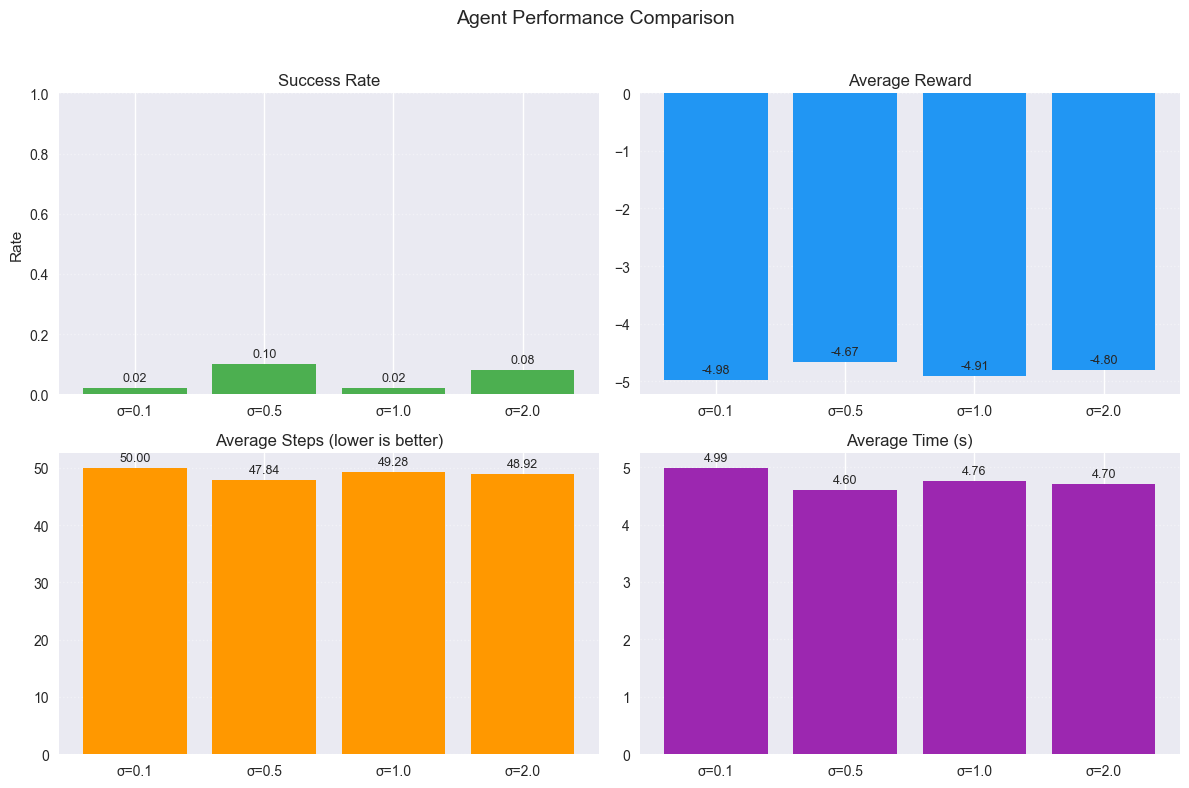

In [4]:
# 结果可视化（成功率/回报/步数/时间 对比）
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')

from utils.metrics import plot_results

file_paths = [cfg["output_file"] for cfg in config_list]
labels = [f"σ={cfg['env_args']['obs_noise_std']}" for cfg in config_list]

plot_results(file_paths, labels)



> 🧠 可以加入信念误差的衡量方式，比如：
> 
>$\text{Belief Error} = \frac{1}{N} \sum_i \| s_{\text{true}}^{(i)} - \hat{s}^{(i)}_{\text{mean}} \|$
> 
> 其中 $\hat{s}_{\text{mean}} $为粒子均值。
>
> 如果你实现了 `belief.mean_state()`，可以在 `BaseExperiment` 中加入这一项统计。


## ✅ 实验总结：

- **噪声越小**：观测越精确，信念更新越准确，POMCP 收敛越快。
- **噪声越大**：观测模糊，导致误更新，规划精度下降。

---

## 🤔 思考问题：

- 粒子数 vs 观测噪声：是否能互相弥补？
- 是否能用启发式 rollout 改进高噪声下表现？
- 可以尝试加入贝叶斯滤波 vs 粒子滤波的对比？

---

## 🔜 下一步建议：

- 加入轨迹回放，看 agent 如何“迷失方向”
- 试试 Q-MDP 等近似算法进行对比（需要 Q 表）

---
